# Simulated-based-inference of 2D Epileptor model

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp
import pandas as pd


import numba
from numba import jit

In [2]:
from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode

from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import torch
import sbi 

import sbi.inference
from sbi.inference.base import infer

from sbi.simulators import linear_gaussian

from sbi.inference import SNPE, SNLE, SNRE, infer, prepare_for_sbi ,simulate_for_sbi
from sbi.inference.posteriors.base_posterior import NeuralPosterior

import sbi.utils as utils
from sbi.utils.get_nn_models import posterior_nn
from sbi.analysis import ActiveSubspace, pairplot

In [4]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [5]:
import warnings
warnings.simplefilter("ignore")

In [6]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [7]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.19.0
Running on torch: v1.8.0
Running on sbi: v0.15.1


In [8]:
plt.style.use('seaborn-talk');
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [9]:
cwd = os.getcwd()
cwd

'/data/SBI/BVEP_SBI'

In [10]:
Res_dir='Res_Epileptor2D_sde_sbi_fitfeatures_dejasim'

### Simulator

In [11]:
def Epileptor2Dmodel(params, constants, sigma, dt, ts):
   
    eta, tau, x_init, z_init  = params[0], params[1], params[2], params[3]
    
    eta.astype(float)
    tau.astype(float)
    x_init.astype(float)
    z_init.astype(float)

    
    # fixed parameters
    I1=constants[0]
    nt=ts.shape[0]
    dt = np.float(dt)
    sigma = np.float(sigma)
    
    # simulation from initial point
    x = np.zeros(nt)  # fast voltage
    z = np.zeros(nt)  # slow voltage
    states=np.zeros((2,nt))

    x[0] = np.float(x_init)    
    z[0] = np.float(z_init) 
    
    for i in range(1, nt):
        dx =1.0 - x[i-1]**3 - 2.0*x[i-1]**2 - z[i-1] + I1   
        dz =(1.0/tau)*(4*(x[i-1]-eta) - z[i-1])
        x[i]=x[i-1] + dt * dx +  np.sqrt(dt)*sigma*np.random.randn()
        z[i]=z[i-1] + dt * dz +  np.sqrt(dt)*sigma*np.random.randn()
        
    states=  np.concatenate((np.array(x).reshape(-1), np.array(z).reshape(-1)))   
    
    return states
     

In [12]:
Epileptor2Dmodel = numba.jit(Epileptor2Dmodel)

In [13]:
def nullclines(X,Y, tau, eta):  
    I1=3.1
    dX =  1.0 - X**3 - 2.0*X**2 - Y + I1 
    dY =  4*(X-eta) - Y
    plt.contour(X, Y, dX, 0, colors='b', linewidths=(2.,))
    plt.contour(X, Y, dY, 0, colors='b', linewidths=(2.,))
    
    x = np.r_[-5:5:0.01]
    z = np.r_[0:10:0.01]
    xx, zz = np.meshgrid(x,z)
    dx = np.zeros([len(z),len(x)])
    dz = np.zeros([len(z),len(x)])

    for ii in range(len(z)):
        for jj in range(len(x)):
            dx[ii,jj] = 1 - x[jj]**3 - 2*x[jj]**2 - z[ii] + I1
            dz[ii,jj] = 1/tau*(4*(x[jj] - eta) - z[ii])
    plt.streamplot(x,z,dx,dz,density=2.0, color='deepskyblue', linewidth=1.5 , zorder=1)

In [14]:
def root_fuc(roots, eta):   
    xx = np.empty(1)
    zz = np.empty(1)
    F = np.empty(2)
    xx = roots[0]
    zz = roots[1]
    I1=3.1
    F[0] =1.0 - xx**3 - 2.0*xx**2 - zz + I1 
    F[1] =4*(xx-eta) - zz
    return np.array([F[0], F[1]])

In [15]:
X, Z = mgrid[-5.0:5.0:100j, 0.0:10.0:100j]

rGuess=array([[-1.,3.]])

In [16]:
eta_true=-1.5
tau_true=10.
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

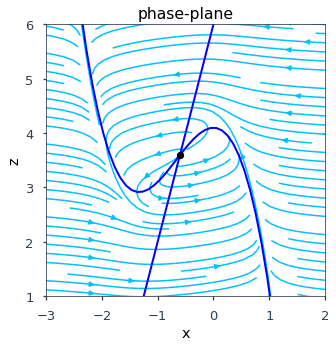

In [17]:
plt.figure(figsize=(5, 5))
nullclines(X,Z, tau_true, eta_true)
#plt.plot(true_roots[0], true_roots[1] , marker="o", markersize=10, color='k')
plt.scatter(true_roots[0], true_roots[1], s=28, facecolors='k', edgecolors='k', linewidth=2., zorder=3)
plt.xlabel('x'); plt.ylabel('z'); 
plt.title('phase-plane')
plt.xlim((-3,2)), plt.ylim((1,6))
plt.show()

In [18]:
def calculate_summary_statistics(x, dt, ts, features):
    """Calculate summary statistics

    Parameters
    ----------
    x : output of the simulator

    Returns
    -------
    np.array, summary statistics
    """


    n_summary = 10

    sum_stats_vec = np.concatenate((np.array([np.mean(x)]),
                                    np.array([np.std(x)]),
                                    np.array([skew(x)]),
                                    np.array([kurtosis(x)]),
                                    ))

    for item in features:

          if item is 'seizures_onset':

                    # initialise array of seizure counts
                    nt=ts.shape[0]
                    v=np.zeros(nt)
                    v= np.array(x)

                    v_th=0
                    ind = np.where(v < v_th)
                    v[ind] = v_th

                    ind = np.where(np.diff(v) < 0)
                    v[ind] = v_th

                    seizure_times = np.array(ts)[ind]
                    seizure_times_stim = seizure_times

                    if seizure_times_stim.shape[0] > 0:
                            seizure_times_stim = seizure_times_stim[np.append(1, np.diff(seizure_times_stim)) > 0.75]

        
                    sum_stats_vec = np.concatenate((sum_stats_vec, 
                                                    np.array([seizure_times_stim.shape[0]]),
                                                   ))


    sum_stats_vec = sum_stats_vec[0:n_summary]     


    return sum_stats_vec


### sanity check simulations

In [19]:
T = 100.0
dt=0.1
ts = np.arange(0, T + dt, dt)
nt=ts.shape[0]

In [20]:
I1=3.1
constants = np.array([I1])

In [21]:
sigma=1*1e-1

In [22]:
# three sets of params (eta, tau, x0, z0)
params = np.array([-1.5, 10., -2.5, 3.5])
params.shape

(4,)

In [23]:
start_time = time.time()
sim = Epileptor2Dmodel(params, constants, sigma, dt, ts)
print(" single sim takes (sec):" , (time.time() - start_time))

 single sim takes (sec): 1.8713524341583252


In [24]:
start_time = time.time()
i=0
sim= Epileptor2Dmodel(params, constants, sigma, dt, ts)

print(" single sim with numba takes (sec):" , (time.time() - start_time))

 single sim with numba takes (sec): 0.0003542900085449219


In [25]:
sim.shape

(2002,)

In [26]:
x_sim=sim[0:nt]
x_sim.shape

(1001,)

In [27]:
_=calculate_summary_statistics(x_sim, dt, ts, features=['seizures_onset'])
_.shape

(5,)

In [28]:
def Epileptor2Dmodel_simulator_wrapper(params):

    params = np.asarray(params)
    
    # time step
    T = 100.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    # fixed parameters
    I1=3.1
    constants = np.array([I1])
    
    sigma=1e-1
    nt=ts.shape[0]
    
    states = Epileptor2Dmodel(params, constants, sigma, dt, ts)

    #summstats = torch.as_tensor(calculate_summary_statistics(states[0:nt], dt, ts, features=['seizures_onset']))

    return states

## 3. Prior over model parameters

In [29]:
prior_min = [-5.0, 0.1, -5.0, 0.0]
prior_max = [0.0, 50.0, 0.0, 5.0]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [30]:
num_params=len(prior_min)
print('numumber of params :', num_params)

numumber of params : 4


### Save simulations

In [31]:
num_sim=1000

In [32]:
mysavepath = os.path.join(Res_dir, 'output_sim/simulated_theta_x_Epileptor2D.npz')
mysavepath

'Res_Epileptor2D_sde_sbi_fitfeatures_dejasim/output_sim/simulated_theta_x_Epileptor2D.npz'

In [33]:
def save_sims(simulator: Callable, prior, mysavepath, num_simulations: int):

    simulator, prior = prepare_for_sbi(simulator, prior)
    
    theta, x = simulate_for_sbi(
        simulator=simulator,
        proposal=prior,
        num_simulations=num_simulations,
        show_progress_bar=True,)
    
    #print(theta,flush=True)
    print( 'theta shape:',theta.shape,flush=True)
    #print(x,flush=True)
    print('data shape:', x.shape,flush=True)

    np.savez(mysavepath,theta=theta,x=x)


In [34]:
start_time = time.time()

save_sims(Epileptor2Dmodel_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one sim took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 4])
data shape: torch.Size([1, 2002])
------------------------------------------------------------
--- one sim took: 2.5453481674194336 seconds ---


In [35]:
start_time = time.time()

save_sims(Epileptor2Dmodel_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

print ("-"*60)
print("---all simulations took:  %s seconds ---" % (time.time() - start_time))

A Jupyter Widget


theta shape: torch.Size([1000, 4])
data shape: torch.Size([1000, 2002])
------------------------------------------------------------
---all simulations took:  0.30613088607788086 seconds ---


### Load simulations and calculate features

In [36]:
sim_deja=np.load(mysavepath)

In [37]:
theta_deja=sim_deja['theta']
x_deja=sim_deja['x']

In [38]:
print( 'theta shape:',theta_deja.shape,flush=True)
print('data shape:', x_deja.shape,flush=True)

theta shape: (1000, 4)
data shape: (1000, 2002)


In [39]:
_=calculate_summary_statistics(x_deja[0,0:nt], dt, ts, features=['seizures_onset'])
num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 5


In [40]:
x_deja_features=np.zeros((num_sim,num_features))
theta_deja_features=np.zeros((num_sim,num_params))

In [41]:
print( 'theta shape:',theta_deja_features.shape,flush=True)
print('data frature shape:', x_deja_features.shape,flush=True)

theta shape: (1000, 4)
data frature shape: (1000, 5)


In [42]:
for i in range(num_sim):
    x_deja_features[i,:]=calculate_summary_statistics(x_deja[i,0:nt], dt, ts, features=['seizures_onset'])
    theta_deja_features[i,:]=theta_deja[i,:]

In [43]:
print( 'theta deja shape:',theta_deja_features.shape,flush=True)
print('data deja feature shape:', x_deja_features.shape,flush=True)

theta deja shape: (1000, 4)
data deja feature shape: (1000, 5)


In [44]:
np.isnan(np.sum(x_deja_features))

False

In [45]:
x = np.array(x_deja_features, dtype='float32')
x     = torch.as_tensor(x)

theta = np.array(theta_deja_features, dtype='float32')
theta = theta.reshape(theta.shape[0],num_params)
theta = torch.as_tensor(theta)

In [46]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([1000, 4])
data feature shape: torch.Size([1000, 5])


### Inference

In [47]:
def myinfer_SNPE(prior, theta, x):
    
    inference = SNPE(prior)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior()

    return posterior

In [48]:
start_time = time.time()

posterior = myinfer_SNPE(prior, theta, x)

print ("-"*60)
print("--- Training neural network took: %s seconds ---" % (time.time() - start_time))

Neural network successfully converged after 212 epochs.
------------------------------------------------------------
--- Training neural network took: 73.27994751930237 seconds ---


### EZ

In [49]:
# true parameters and respective labels
labels_params = [r'$\eta$', r'$\tau$', r'$x_{init}$', r'$z_{init}$']

In [50]:
true_params = np.array([-1.6, 10., -2.5, 3.5])

In [51]:
y_obs=Epileptor2Dmodel(true_params, constants, sigma, dt, ts)#+sigma*randn(2*ts.shape[0])

In [52]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

In [53]:
x_obs_summary_statistics=calculate_summary_statistics(x_obs, dt, ts, features=['seizures_onset'])

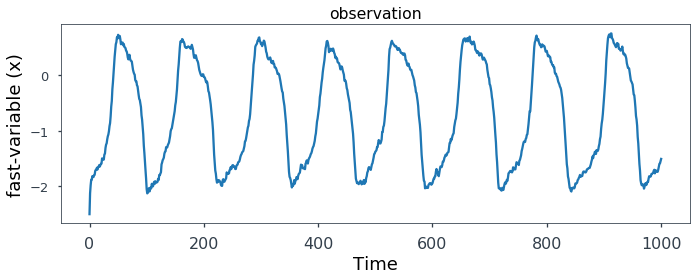

In [54]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_ez.eps"), doi=800)
plt.show()

In [55]:
x_obs_summary_statistics

array([-0.72237935,  0.95956721,  0.07826681, -1.59388061,  8.        ])

### Posterior EZ

In [56]:
num_samples=10000

In [57]:
posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

A Jupyter Widget

In [58]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_ez_posterior_samples.npy') , posterior_samples)

In [59]:
num_params=posterior_samples.shape[1]

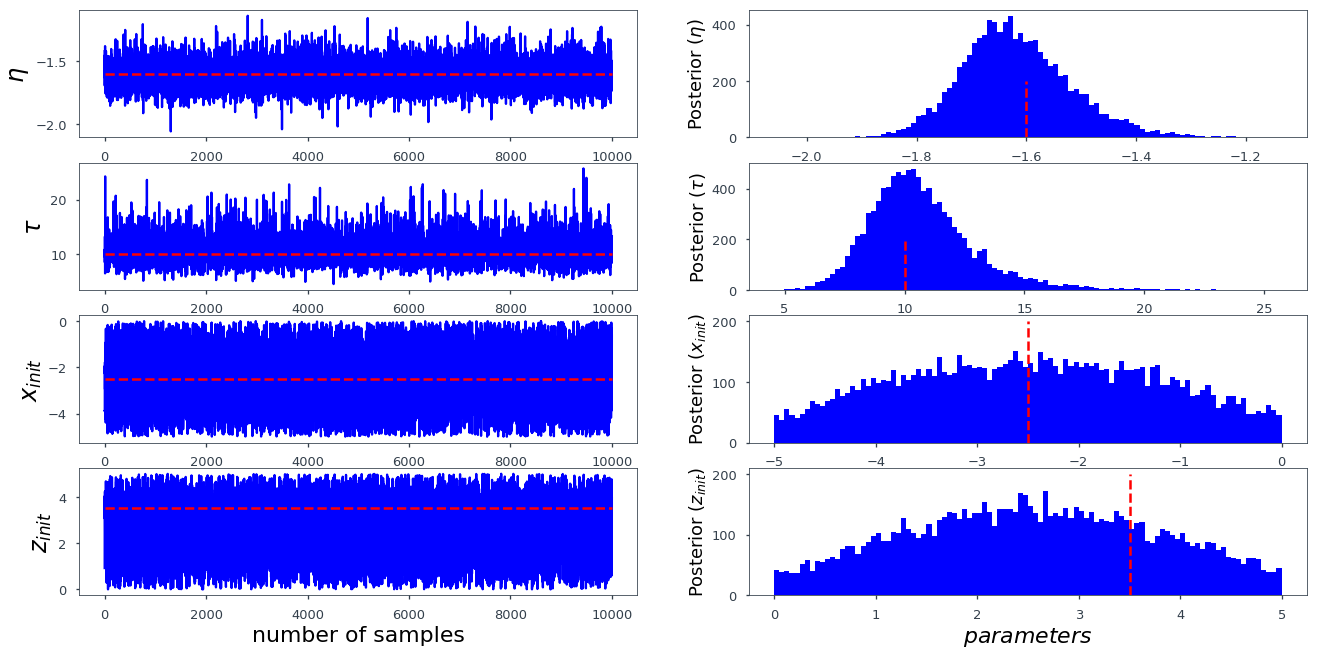

In [60]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=200, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_ez.eps"), doi=800)    
plt.show()

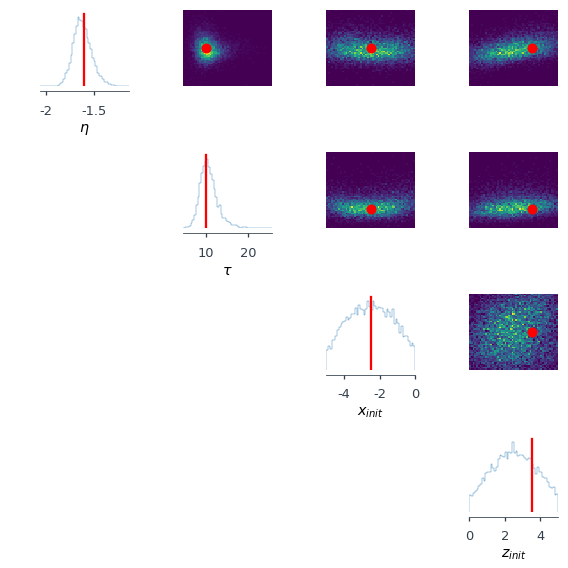

In [61]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_ez.eps"), doi=800) 
plt.show()

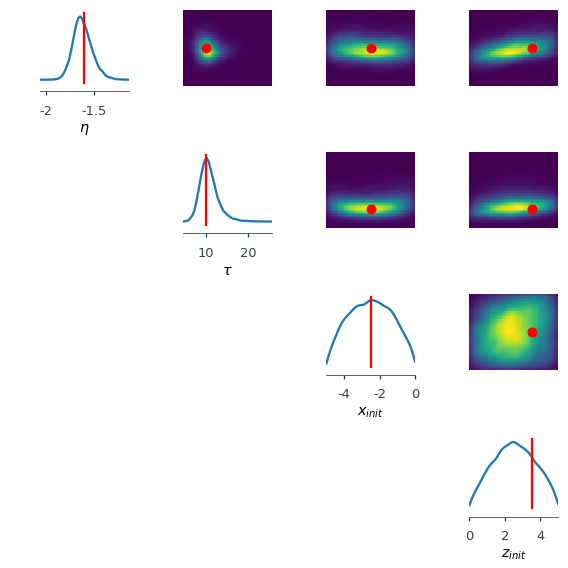

In [62]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_ez.eps"), doi=800) 
plt.show()

In [63]:
y_fit=Epileptor2Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, sigma, dt, ts)

In [64]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [65]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_ez_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_ez_y_fit.npy') , y_fit)

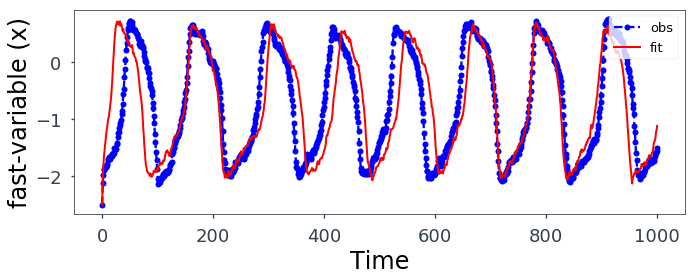

In [66]:
plt.figure(figsize=(10,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_ez.eps"), doi=800) 
plt.show()

In [67]:
eta_true=true_params[0]
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

In [68]:
eta_est=np.mean(posterior_samples[:,0])
est_roots = fsolve(root_fuc,rGuess, args=(eta_est,))

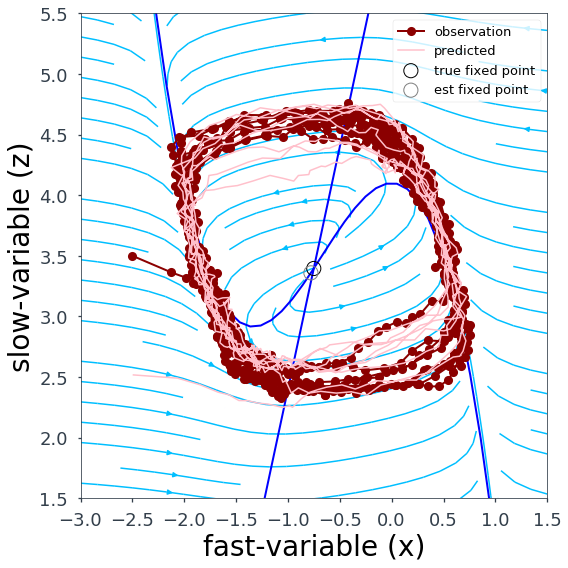

In [69]:
plt.figure(figsize=(8,8))
plt.plot(x_obs, z_obs, '-o', color='darkred', alpha=1, linewidth=2., zorder=3, label='observation')
plt.plot(x_fit, z_fit, color='pink', alpha=1, linewidth=1.5, zorder=3,  label='predicted')
nullclines(X,Z,  tau_true, eta_true)
#plt.plot(true_roots_ez[0], true_roots_ez[1] , marker="o", markersize=14, color='cyan', label='true fixed point')
#plt.plot(est_roots_ez[0], est_roots_ez[1] , marker="o", markersize=14, color='y', label='est fixed point')
plt.scatter(true_roots[0],true_roots[1] , s=200, facecolors='none', edgecolors='k', linewidth=1., zorder=4, label='true fixed point') 
plt.scatter(est_roots[0], est_roots[1] , s=200, facecolors='none', linewidth=1., edgecolors='grey', zorder=5, label='est fixed point') 
plt.xlabel('fast-variable (x)', fontsize=28); 
plt.ylabel('slow-variable (z)', fontsize=28); 
plt.legend(loc='upper right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axis([-3, 1.5, 1.5, 5.5])
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_ez.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_ez.eps"), doi=800) 
plt.show()

In [70]:
sensitivity = ActiveSubspace(posterior.set_default_x(x_obs_summary_statistics))
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

A Jupyter Widget

In [71]:
print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([5.1833e-07, 1.0912e-06, 8.0012e-05, 3.4958e-04]) 

Eigenvectors: 
 tensor([[ 0.0171, -0.0276,  0.1312, -0.9908],
        [ 0.0241, -0.0259, -0.9909, -0.1300],
        [ 0.5898,  0.8074, -0.0051, -0.0130],
        [ 0.8070, -0.5887,  0.0305,  0.0344]])


In [72]:
sensitivity_vals = pd.Series(e_vals/min(e_vals), index=labels_params)

df = pd.DataFrame({'sensitivity_vals' : sensitivity_vals})
df = df.sort_values(by='sensitivity_vals')

my_range=list(range(1,len(df.index)+1))

In [73]:
df

,sensitivity_vals
$\eta$,1.000000
$\tau$,2.105132
$x_{init}$,154.363297
$z_{init}$,674.435181


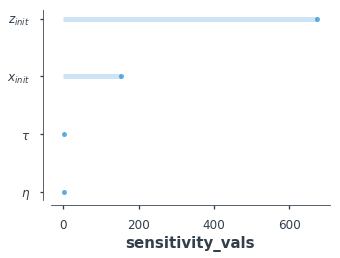

In [74]:
fig, ax = plt.subplots(figsize=(5,3.5))

plt.hlines(y=my_range, xmin=0, xmax=df['sensitivity_vals'], color='#007ACC', alpha=0.2, linewidth=5)
plt.plot(df['sensitivity_vals'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

plt.yticks(my_range, df.index)

ax.set_xlabel('sensitivity_vals', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(0,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"sensitivity_vals.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"sensitivity_vals.eps"), doi=800) 

plt.show()

### PZ

In [75]:
true_params = np.array([-2.1, 10., -2.5, 3.5])

In [76]:
y_obs=Epileptor2Dmodel(true_params, constants, sigma, dt, ts)#+sigma*randn(2*ts.shape[0])

In [77]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

In [78]:
x_obs_summary_statistics=calculate_summary_statistics(x_obs, dt, ts, features=['seizures_onset'])

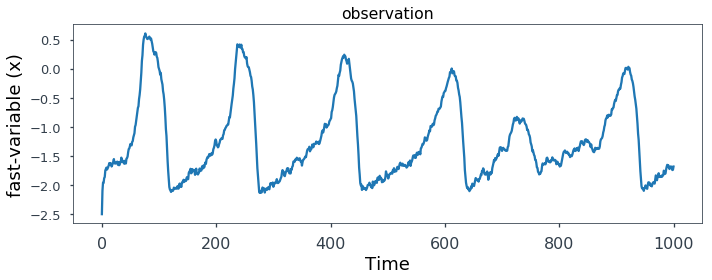

In [79]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_pz.eps"), doi=800)
plt.show()

In [80]:
x_obs_summary_statistics

array([-1.24933231,  0.68942632,  0.91367186, -0.16382009,  5.        ])

### Posterior PZ

In [81]:
num_samples=10000

In [82]:
posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

A Jupyter Widget

In [83]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_pz_posterior_samples.npy') , posterior_samples)

In [84]:
num_params=posterior_samples.shape[1]

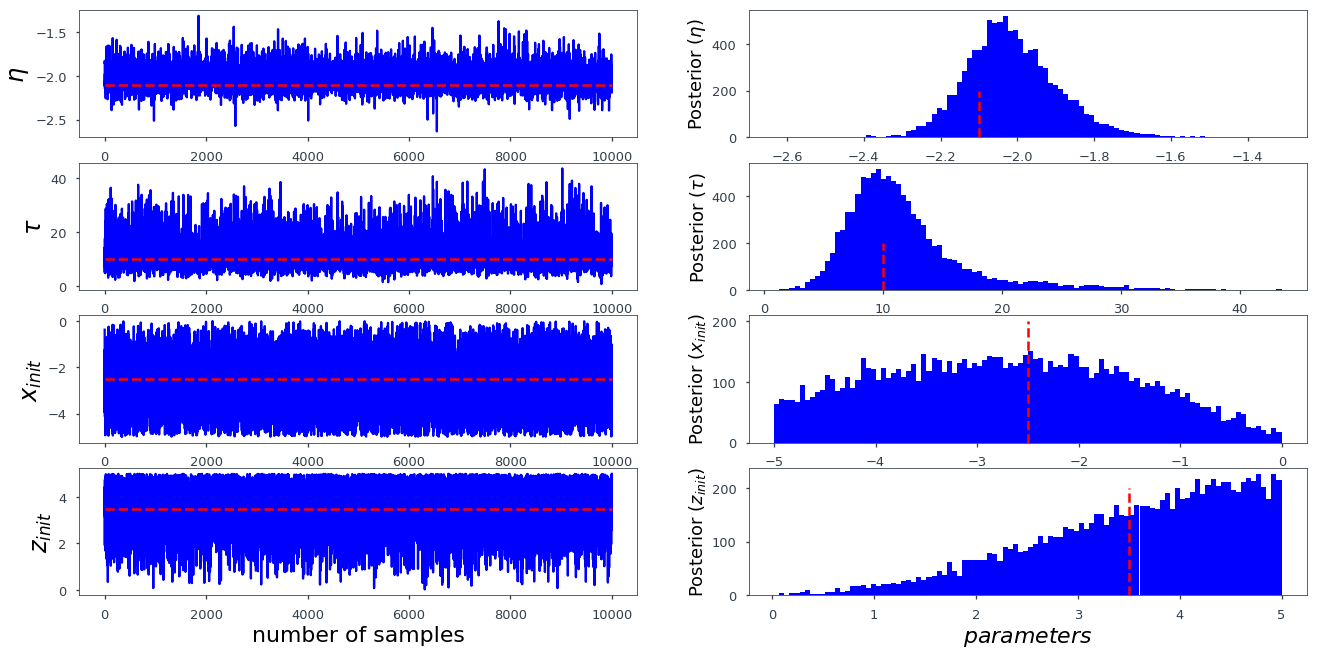

In [85]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=200, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_pz.eps"), doi=800)    
plt.show()

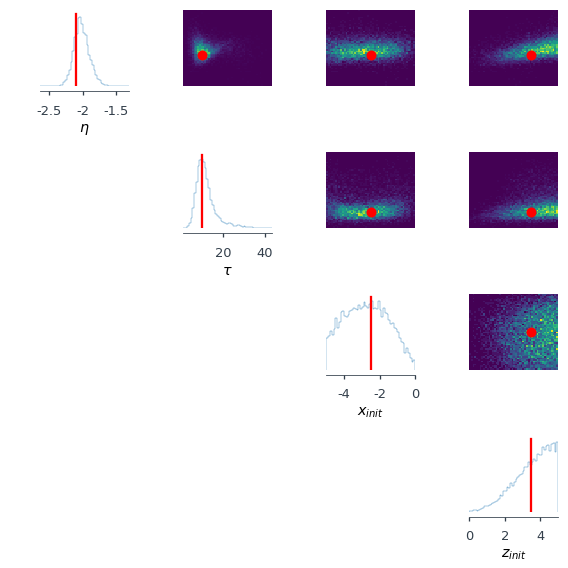

In [86]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_pz.eps"), doi=800) 
plt.show()

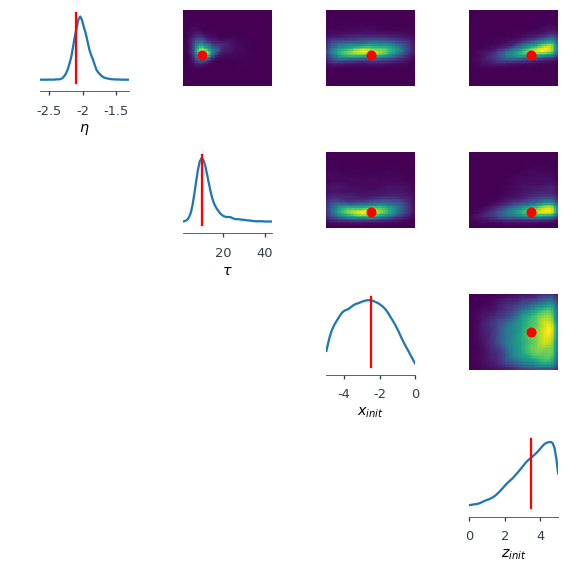

In [87]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_pz.eps"), doi=800) 
plt.show()

In [88]:
y_fit=Epileptor2Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, sigma, dt, ts)

In [89]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [90]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_pz_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_pz_y_fit.npy') , y_fit)

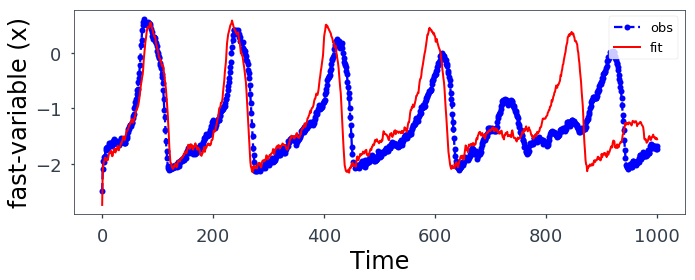

In [91]:
plt.figure(figsize=(10,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_pz.eps"), doi=800) 
plt.show()

In [92]:
eta_true=true_params[0]
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

In [93]:
eta_est=np.mean(posterior_samples[:,0])
est_roots = fsolve(root_fuc,rGuess, args=(eta_est,))

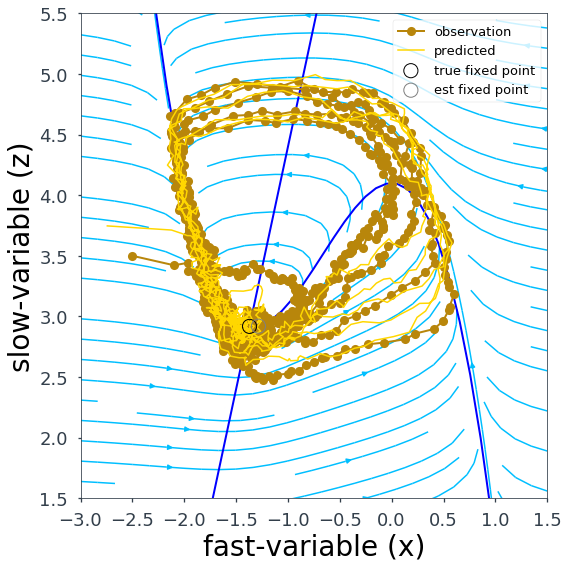

In [94]:
plt.figure(figsize=(8,8))
plt.plot(x_obs, z_obs, '-o', color='darkgoldenrod', alpha=1, linewidth=2., zorder=3, label='observation')
plt.plot(x_fit, z_fit, color='gold', alpha=1, linewidth=1.5, zorder=3,  label='predicted')
nullclines(X,Z,  tau_true, eta_true)
plt.scatter(true_roots[0],true_roots[1] , s=200, facecolors='none', edgecolors='k', linewidth=1., zorder=4, label='true fixed point') 
plt.scatter(est_roots[0], est_roots[1] , s=200, facecolors='none', linewidth=1., edgecolors='grey', zorder=5, label='est fixed point') 
plt.xlabel('fast-variable (x)', fontsize=28); 
plt.ylabel('slow-variable (z)', fontsize=28); 
plt.legend(loc='upper right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axis([-3, 1.5, 1.5, 5.5])
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_pz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_p1.eps"), doi=800) 
plt.show()

In [95]:
sensitivity = ActiveSubspace(posterior.set_default_x(x_obs_summary_statistics))
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

A Jupyter Widget

In [96]:
print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([8.9945e-07, 1.4394e-06, 3.1733e-05, 2.8089e-04]) 

Eigenvectors: 
 tensor([[ 0.0344, -0.0093, -0.0450,  0.9984],
        [ 0.0834, -0.0505,  0.9944,  0.0415],
        [ 0.4571,  0.8893,  0.0072, -0.0071],
        [ 0.8848, -0.4544, -0.0957, -0.0390]])


In [97]:
sensitivity_vals = pd.Series(e_vals/min(e_vals), index=labels_params)

df = pd.DataFrame({'sensitivity_vals' : sensitivity_vals})
df = df.sort_values(by='sensitivity_vals')

my_range=list(range(1,len(df.index)+1))

In [98]:
df

,sensitivity_vals
$\eta$,1.000000
$\tau$,1.600321
$x_{init}$,35.280407
$z_{init}$,312.296326


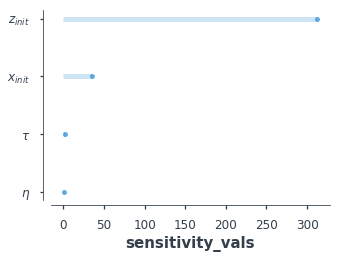

In [99]:
fig, ax = plt.subplots(figsize=(5,3.5))

plt.hlines(y=my_range, xmin=0, xmax=df['sensitivity_vals'], color='#007ACC', alpha=0.2, linewidth=5)
plt.plot(df['sensitivity_vals'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

plt.yticks(my_range, df.index)

ax.set_xlabel('sensitivity_vals', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(0,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"sensitivity_vals.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"sensitivity_vals.eps"), doi=800) 

plt.show()

### HZ

In [100]:
true_params = np.array([-3., 10., -2.5, 3.5])

In [101]:
y_obs=Epileptor2Dmodel(true_params, constants, sigma, dt, ts)#+sigma*randn(2*ts.shape[0])

In [102]:
x_obs, z_obs=y_obs[0:nt], y_obs[nt:2*nt]

In [103]:
x_obs_summary_statistics=calculate_summary_statistics(x_obs, dt, ts, features=['seizures_onset'])

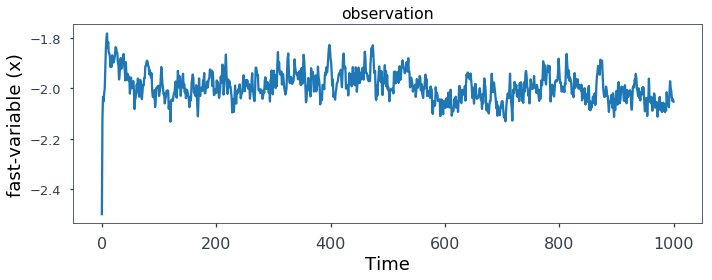

In [104]:
plt.figure(figsize=(10,4))
plt.plot(x_obs)
plt.title('observation')
plt.ylabel('fast-variable (x)', fontsize=18); 
plt.xlabel('Time', fontsize=18); 
plt.xticks(fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"obs_hz.eps"), doi=800)
plt.show()

In [105]:
x_obs_summary_statistics

array([-1.99226437,  0.05872111, -0.28047996,  5.27520187,  0.        ])

### Posterior HZ

In [106]:
num_samples=10000

In [107]:
posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

A Jupyter Widget

In [108]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_hz_posterior_samples.npy') , posterior_samples)

In [109]:
num_params=posterior_samples.shape[1]

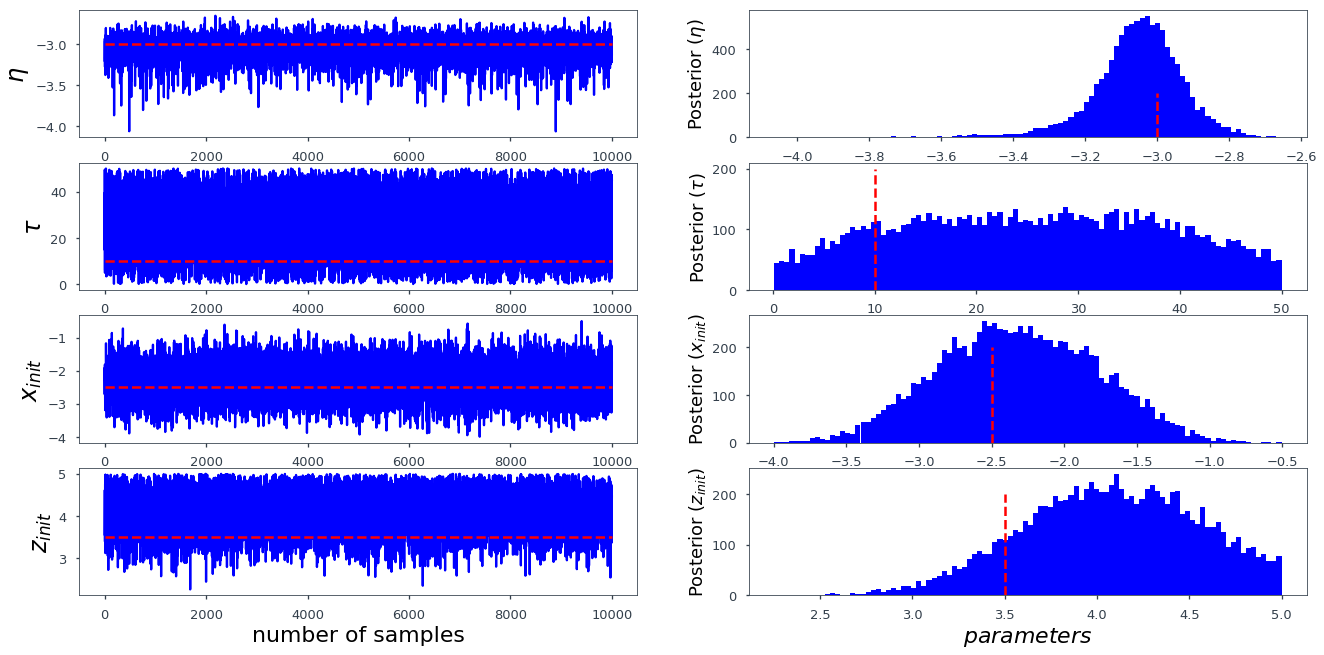

In [110]:
plt.figure(figsize=(22,22))

for i in range(num_params):
    plt.subplot(2*num_params,2,2*i+1)
    plt.plot(posterior_samples[:,i], color='blue')
    plt.hlines(y=true_params[i], xmin=0., xmax=num_samples, linewidth=2.5, color = 'red', linestyle='--', zorder=5)
    plt.xlabel('number of samples',  fontsize=22)
    plt.ylabel(labels_params[i],  fontsize=24)
    plt.subplot(2*num_params,2,2*i+2)
    plt.hist(posterior_samples[:,i], bins=100, color='b')
    plt.vlines(x=true_params[i], ymin=0., ymax=200, linewidth=2.5, color = 'r', linestyle='--', zorder=5)
    plt.xlabel(r'$parameters$',  fontsize=22)
    plt.ylabel('Posterior ('+str(labels_params[i])+')',  fontsize=18)
#plt.tight_layout();   
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_obs_hz.eps"), doi=800)    
plt.show()

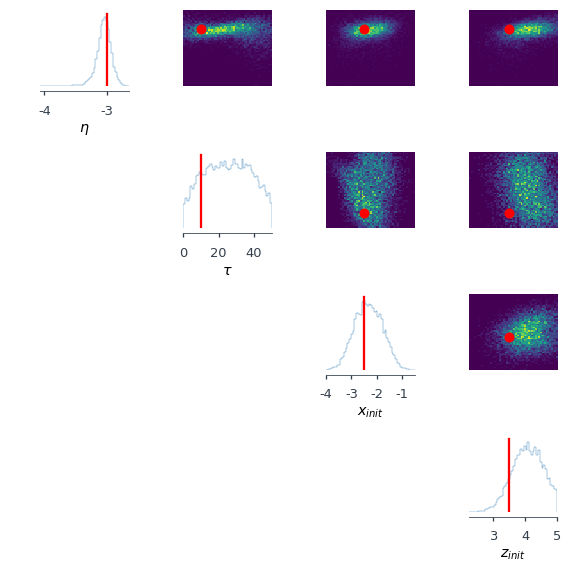

In [111]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_obs_hz.eps"), doi=800) 
plt.show()

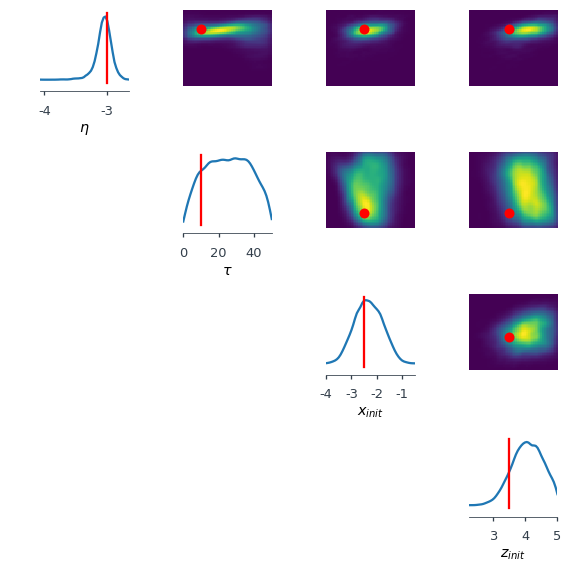

In [112]:
fig, axes = utils.pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=labels_params,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Posterior_pairplot_kde_obs_hz.eps"), doi=800) 
plt.show()

In [113]:
y_fit=Epileptor2Dmodel(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, sigma, dt, ts)

In [114]:
x_fit, z_fit=y_fit[0:nt], y_fit[nt:2*nt]

In [115]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_hz_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'Epileptor2D_sde_sbi_fitstatsummary_hz_y_fit.npy') , y_fit)

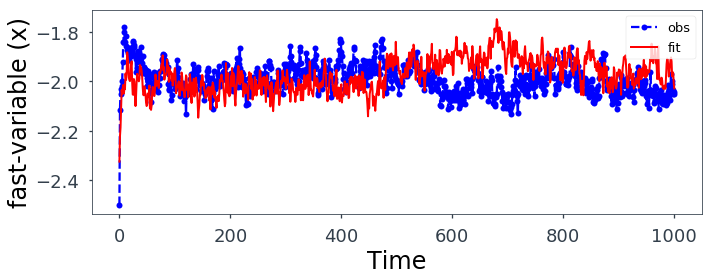

In [116]:
plt.figure(figsize=(10,4))
plt.plot(x_obs, '--o', color='b', markersize=6,  label='obs')
plt.plot(x_fit, '-', color='r', lw=2, markersize=4,  label='fit')
plt.ylabel('fast-variable (x)', fontsize=24); 
plt.xlabel('Time', fontsize=24); 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper right')
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_obs_hz.eps"), doi=800) 
plt.show()

In [117]:
eta_true=true_params[0]
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

In [118]:
eta_est=np.mean(posterior_samples[:,0])
est_roots = fsolve(root_fuc,rGuess, args=(eta_est,))

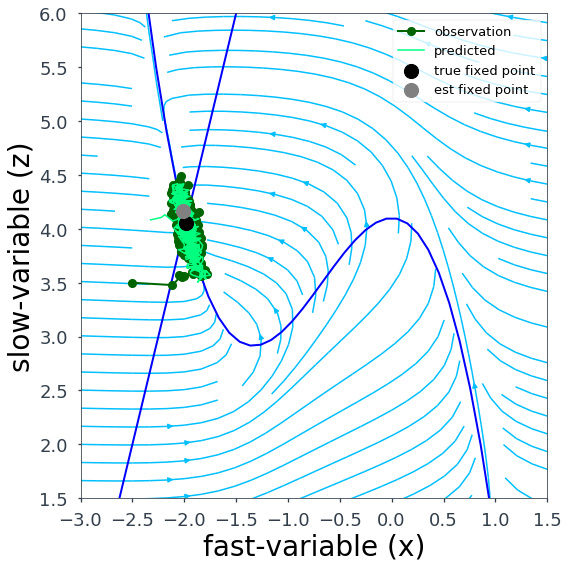

In [119]:
plt.figure(figsize=(8,8))
plt.plot(x_obs, z_obs, '-o', color='darkgreen', alpha=1, linewidth=2., zorder=3, label='observation')
plt.plot(x_fit, z_fit, color='springgreen', alpha=1., linewidth=1.5, zorder=3,  label='predicted')
nullclines(X,Z,  tau_true, eta_true)
plt.scatter(true_roots[0],true_roots[1] , s=200, facecolors='k', edgecolors='k', linewidth=1., zorder=4, label='true fixed point') 
plt.scatter(est_roots[0], est_roots[1] , s=200, facecolors='grey', linewidth=1., edgecolors='grey', zorder=5, label='est fixed point') 
plt.xlabel('fast-variable (x)', fontsize=28); 
plt.ylabel('slow-variable (z)', fontsize=28); 
plt.legend(loc='upper right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axis([-3, 1.5, 1.5, 6.])
plt.tight_layout();
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_hz.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Fitted_phaseplane_obs_hz.eps"), doi=800) 
plt.show()

In [120]:
sensitivity = ActiveSubspace(posterior.set_default_x(x_obs_summary_statistics))
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

A Jupyter Widget

In [121]:
print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([2.3175e-06, 8.2879e-06, 1.4315e-05, 3.0863e-04]) 

Eigenvectors: 
 tensor([[ 0.0083, -0.0851,  0.0123,  0.9963],
        [ 0.9964, -0.0592,  0.0594, -0.0141],
        [-0.0767, -0.3433,  0.9352, -0.0402],
        [-0.0357, -0.9335, -0.3489, -0.0751]])


In [122]:
sensitivity_vals = pd.Series(e_vals/min(e_vals), index=labels_params)

df = pd.DataFrame({'sensitivity_vals' : sensitivity_vals})
df = df.sort_values(by='sensitivity_vals')

my_range=list(range(1,len(df.index)+1))

In [123]:
df

,sensitivity_vals
$\eta$,1.000000
$\tau$,3.576239
$x_{init}$,6.177021
$z_{init}$,133.174347


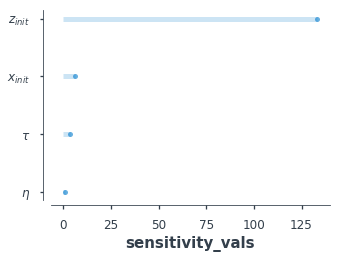

In [124]:
fig, ax = plt.subplots(figsize=(5,3.5))

plt.hlines(y=my_range, xmin=0, xmax=df['sensitivity_vals'], color='#007ACC', alpha=0.2, linewidth=5)
plt.plot(df['sensitivity_vals'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

plt.yticks(my_range, df.index)

ax.set_xlabel('sensitivity_vals', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(0,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"sensitivity_vals.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"sensitivity_vals.eps"), doi=800) 

plt.show()